In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (16, 12)

#Tensorflow Fix
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Entrenamiento CNN

El set total de imagenes es de 1800, de estas se utilizará un 20% para validación y 80% para entrenamiento y pruebas.

# Carga de datos

Carga de archivo CSV con el nombre de la imagen y la cantidad de hojas:

In [2]:
cesped = pd.read_csv('02-dataset/cesped.csv')
cesped = cesped[["file", "hojas"]]
print("Registros:", len(cesped))
cesped.head()

Registros: 1800


,file,hojas
0,imagen-0.jpg,4766
1,imagen-1.jpg,4606
2,imagen-2.jpg,4584
3,imagen-3.jpg,4705
4,imagen-4.jpg,4730


Grafica de densidad de hojas por imagen:

<AxesSubplot:ylabel='Density'>

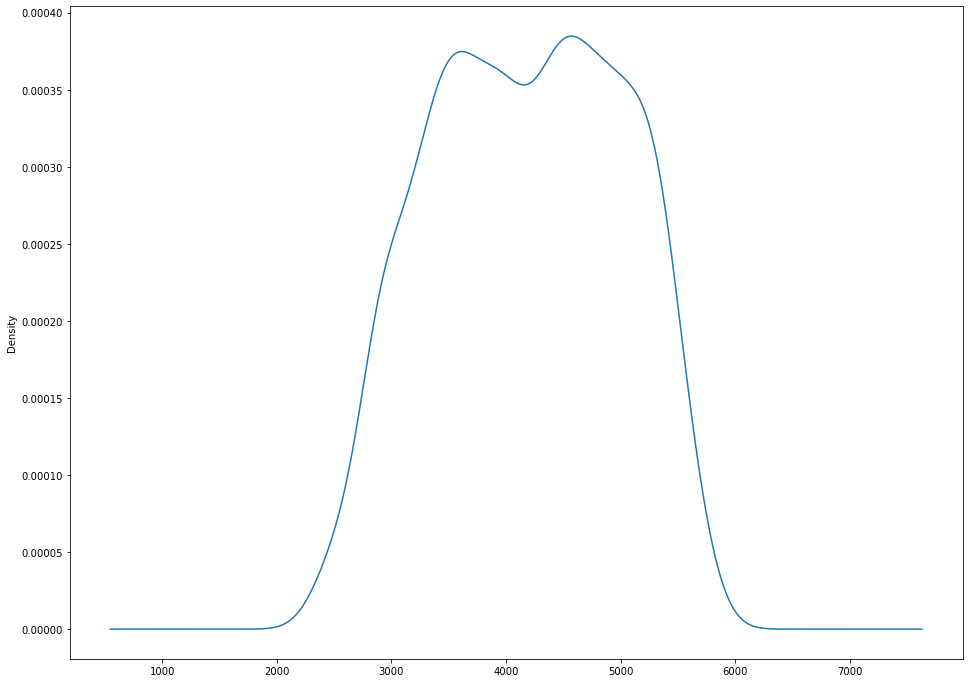

In [3]:
cesped.hojas.plot.kde()

Previsualización de seis imagenes aleatoreas:

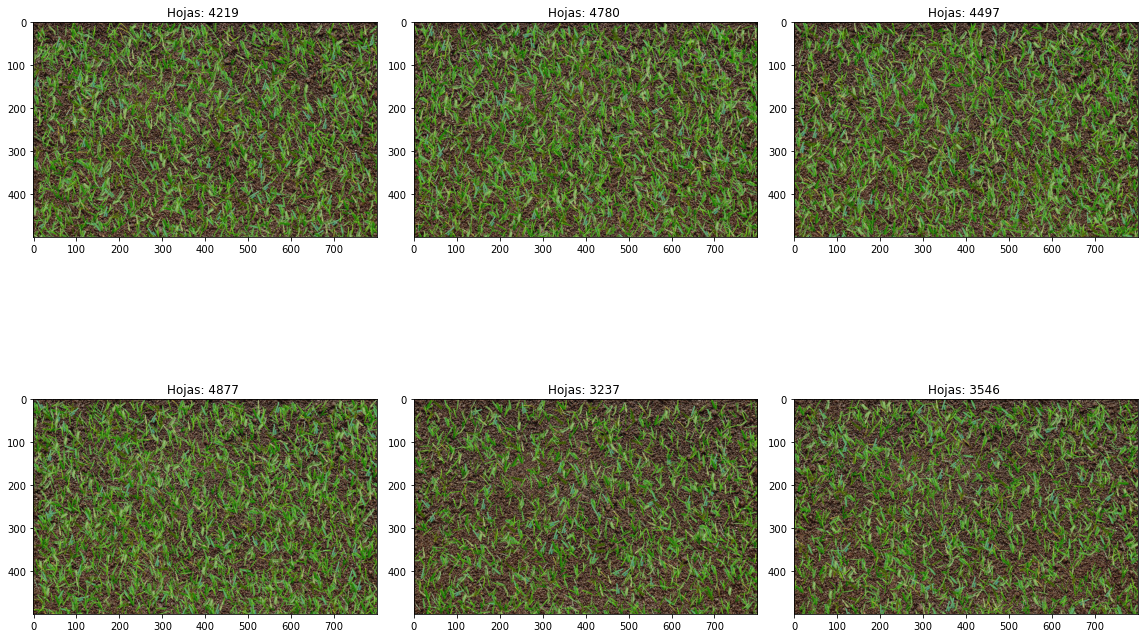

In [4]:
f, axarr = plt.subplots(2,3)
index = np.random.choice(1800, size=6, replace=False)
for i in range(0, 2):
    for j in range(0, 3):
        pos = index[i*3 + j]
        img = Image.open('02-dataset/cesped/'+cesped.iloc[pos, 0])
        axarr[i,j].imshow(img)
        axarr[i,j].set_title('Hojas: '+str(cesped.iloc[pos, 1])+" ")
f.tight_layout()

# Carga de imagenes para entrenamiento

Las imagenes se cargarán con TF en un dataset de forma aleatoria:

In [5]:
list_ds = tf.data.Dataset.list_files('./02-dataset/cesped/*', shuffle=True)
print(len(list_ds))

1800


Creando un array con la cantidad de hojas segun el orden aleatorio:

In [6]:
list_ds_y = []
list_ds_x = []
for i in list_ds:
    nombre = i.numpy().decode('utf-8').split("\\")
    mask = cesped.file == nombre[-1]
    row = cesped[mask]
    list_ds_x.append(row.iloc[0,0])
    list_ds_y.append(row.iloc[0,1])
print("Cantidad de registros:", len(list_ds_y))
print("Imagenes:",list_ds_x[0:5])
print("Hojas:", list_ds_y[0:5])

Cantidad de registros: 1800
Imagenes: ['imagen-1484.jpg', 'imagen-605.jpg', 'imagen-1290.jpg', 'imagen-271.jpg', 'imagen-934.jpg']
Hojas: [5376, 2961, 4088, 5253, 4313]


Convirtiendo labels a tensores:

In [7]:
listf_x = tf.convert_to_tensor(np.array(list_ds_x), dtype=tf.string)
listf_y = tf.convert_to_tensor(np.array(list_ds_y), dtype=tf.float32) 

Tratamiento del dataset:

In [8]:
image_width = 500
image_height = 500

def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.shape(img), tf.image.resize(img, [image_width, image_height])

def process_path(path, tf_x, tf_y):
    img = tf.io.read_file(path)
    shape, img = decode_img(img)
    img = tf.divide(img, 255)
    
    parts = tf.strings.split(path, os.path.sep)
    
    mask = tf.equal(tf_x, parts[-1])
    hojas = tf.gather(tf_y, tf.argmax(mask))
    
    return img, {"hojas": hojas, "path": parts[-1]}

def process_list(path):
    return process_path(path, listf_x, listf_y)

list_ds_final = list_ds.map(process_list, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Configuración de rendimiento.
Esta función creará batches de 10 imagenes. Si son 1800 imagenes el set total será de 180 batches.

In [9]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=256)
    ds = ds.batch(10)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

list_ds_final = configure_for_performance(list_ds_final)
len(list_ds_final)

180

Funciones para separar la columna de clasificación carro y coordenadas del nombre de la imagen:

In [10]:
def get_only_dataset(dt_0, dt_1):
    return dt_0, {"hojas": dt_1["hojas"]}

def get_validation_dataset(dt_0, dt_1):
    return {"hojas": dt_1["hojas"], "path": dt_1["path"]}

Separación de datos para entrenamiento:

In [11]:
val_size = int(len(list_ds_final) * 0.2)
train_ds_data = list_ds_final.skip(val_size)
val_ds = list_ds_final.take(val_size)

val_size_data = int(len(train_ds_data) * 0.2)
train_ds = train_ds_data.skip(val_size_data)
test_ds = train_ds_data.take(val_size_data)

validation_dataset = val_ds.map(get_validation_dataset)
val_ds = val_ds.map(get_only_dataset)
train_ds = train_ds.map(get_only_dataset)
test_ds = test_ds.map(get_only_dataset)

# Proceso convolucional

In [12]:
#Capa de entrada
input_layer = Input(shape=(image_width, image_height, 3))

#Capa convolucional paralela 1
ccp1 = Conv2D(10, kernel_size=(9, 9), padding='same', activation='relu')(input_layer)
ccp1MP = MaxPooling2D(pool_size=(2, 2))(ccp1)

#Capa convolucional paralela 2
ccp2 = Conv2D(14, kernel_size=(7, 7), padding='same', activation='relu')(input_layer)
ccp2MP = MaxPooling2D(pool_size=(2, 2))(ccp2)

#Capa convolucional paralela 3
ccp3 = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
ccp3MP = MaxPooling2D(pool_size=(2, 2))(ccp3)

#Concatenación de capas paralelas
cp = Concatenate()([ccp1MP, ccp2MP, ccp3MP])

#Capa convolucional 1
cc1 = Conv2D(40, kernel_size=(3,3), padding='same', activation='relu')(cp)

#Capa convolucional 2
cc2 = Conv2D(60, kernel_size=(3,3), padding='same', activation='relu')(cc1)
cc2MP = MaxPooling2D(pool_size=(2, 2))(cc2)

#Capa convolucional 3
cc3 = Conv2D(40, kernel_size=(3,3), padding='same', activation='relu')(cc2MP)
cc3MP = MaxPooling2D(pool_size=(2, 2))(cc3)

#Capa convolucional 4
cc4 = Conv2D(20, kernel_size=(3,3), padding='same', activation='relu')(cc3MP)

#Capa convolucional 5
cc5 = Conv2D(10, kernel_size=(3,3), padding='same', activation='relu')(cc4)

capa_flatten = Flatten()(cc5)

# Optimizador

In [13]:
adagrad = Adagrad( learning_rate=0.01,
    initial_accumulator_value=0.01,
    epsilon=1e-06,
    name="Adagrad"
)

# Fase artificial

In [14]:
#Capa artificial 1
ca1 = Dense(20, activation="relu", kernel_initializer=GlorotNormal())(capa_flatten)
ca1R = Dropout(0.1, input_shape=(20,))(ca1)

#Capa artificial 2
ca2 = Dense(10, activation="relu", kernel_initializer=GlorotNormal())(ca1R)
ca2R = Dropout(0.1, input_shape=(10,))(ca2)

#Salida
cout = Dense(1, activation="relu", name="hojas")(ca2R)

#Modelo
modelo = Model(inputs=input_layer, outputs=[cout])

modelo.compile(
    loss = {"hojas":MeanSquaredError()}, 
    optimizer = adagrad, 
    metrics = {"hojas":[MeanSquaredError()]}
)

# Entrenamiento

In [15]:
#Early Stop después de 100 epochs
my_early_top = EarlyStopping(monitor='loss', patience=5)

#Guardar modelo con la mejor presición
modelo_checkpoint_callback = ModelCheckpoint(
    filepath='03-modelo/modelos/modelo-checkpoint',
    save_weights_only=True,
    monitor='mse',
    mode='min',
    save_best_only=True)

#Entrenamiento
historial = modelo.fit(
    train_ds.repeat(), 
    validation_data=test_ds.repeat(),
    epochs=5,
    batch_size=4,
    steps_per_epoch=29,
    validation_steps=4,
    validation_batch_size=7,
    callbacks=[my_early_top, modelo_checkpoint_callback]
)

Epoch 1/5
29/29 [==============================] - 77s 2s/step - loss: 22034672.0000 - mean_squared_error: 22034668.0000 - val_loss: 1479277.2500 - val_mean_squared_error: 1479277.1250
Epoch 2/5
29/29 [==============================] - 69s 2s/step - loss: 4703029.5000 - mean_squared_error: 4703029.0000 - val_loss: 2120386.5000 - val_mean_squared_error: 2120386.5000
Epoch 3/5
29/29 [==============================] - 67s 2s/step - loss: 4150231.5000 - mean_squared_error: 4150231.2500 - val_loss: 1004010.3750 - val_mean_squared_error: 1004010.5000
Epoch 4/5
29/29 [==============================] - 55s 2s/step - loss: 4601753.0000 - mean_squared_error: 4601753.5000 - val_loss: 763512.4375 - val_mean_squared_error: 763512.5000
Epoch 5/5
29/29 [==============================] - 66s 2s/step - loss: 3728543.2500 - mean_squared_error: 3728542.5000 - val_loss: 1299240.2500 - val_mean_squared_error: 1299240.2500


# Predicción

In [52]:
predicciones = []
valores_reales = []
for images, labels in val_ds:
    prediccion_batch = modelo.predict(images)
    predicciones.append(prediccion_batch.reshape(len(prediccion_batch)))
    valores_reales.append(labels["hojas"].numpy())
predicciones = np.array(predicciones).flatten()
valores_reales = np.array(valores_reales).flatten()

Error cuadrático medio:

In [55]:
mse = mean_squared_error(predicciones, valores_reales)
print("hojas MSE: %.4f" % mse)
print("hojas error: %.4f" % np.sqrt(mse))

hojas MSE: 1379072.1250
hojas error: 1174.3390


Gráfica de comparación:

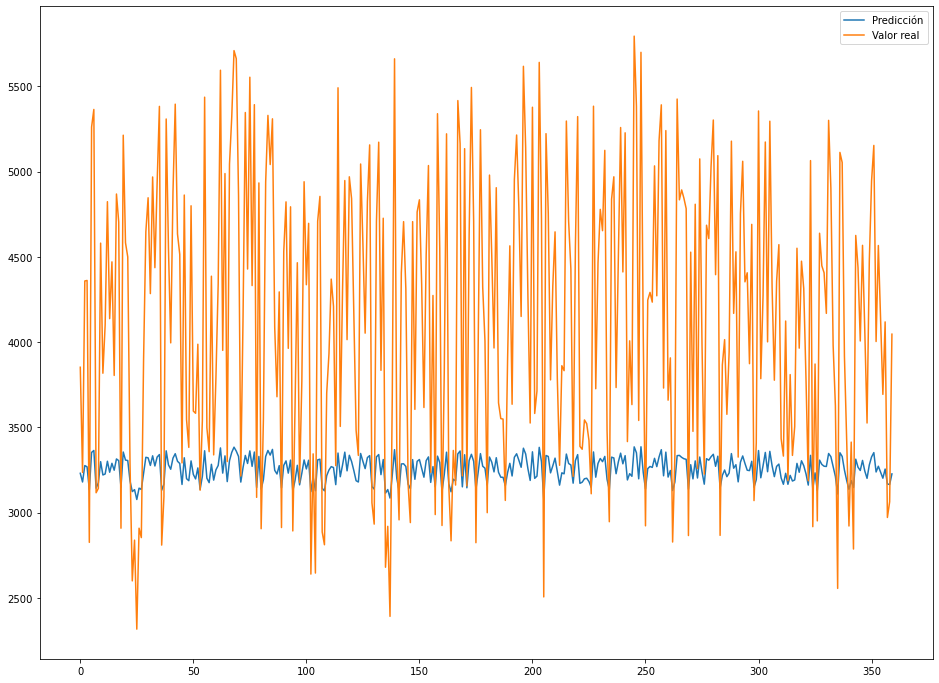

In [57]:
plt.plot(range(0, len(predicciones)), predicciones, label = "Predicción")
plt.plot(range(0, len(valores_reales)), valores_reales, label = "Valor real")
plt.legend()
plt.show()

In [ ]:
Guardando el modelo

In [ ]:
modelo.save_weights('03-modelo/modelos/modelo-save')